In [1]:
!pip install -U datasets pandas numpy scikit-learn nltk matplotlib wordcloud langdetect joblib


In [2]:
import os, re, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from datasets import load_dataset

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
nltk.download("punkt")
nltk.download("stopwords")

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

try:
    from langdetect import detect
    LANGDETECT_AVAILABLE = True
except:
    LANGDETECT_AVAILABLE = False

os.makedirs("outputs", exist_ok=True)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:

dataset = load_dataset("imdb")

train_df = dataset["train"].to_pandas()
test_df = dataset["test"].to_pandas()


train_df, valid_df = train_test_split(
    train_df, test_size=0.2, random_state=42, stratify=train_df["label"]
)

print("Train size:", len(train_df))
print("Validation size:", len(valid_df))
print("Test size:", len(test_df))
train_df.head()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Train size: 20000
Validation size: 5000
Test size: 25000


,text,label
20022,I have always been a huge James Bond fanatic! ...,1
4993,I am a Christian and I say this movie had terr...,0
24760,"Neatly sandwiched between THE STRANGER, a smal...",1
13775,Years ago I did follow a soap on TV. So I was ...,1
20504,"Here's a gritty, get-the-bad guys revenge stor...",1


In [4]:
def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = re.sub(r"<br\s*/?>", " ", s)
    s = re.sub(r"<[^>]+>", " ", s)
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def tokenize_words(s: str):
    return re.findall(r"[a-zA-Z0-9']+", s)

def count_sentences(s: str) -> int:
    try:
        return len(sent_tokenize(s))
    except:
        return len(re.split(r"[.!?]+", s))

EN_STOPWORDS = set(stopwords.words("english"))


In [5]:
for df in (train_df, valid_df, test_df):
    df["text_clean"] = df["text"].apply(clean_text)
    df["char_count"] = df["text_clean"].str.len()
    df["word_count"] = df["text_clean"].apply(lambda s: len(tokenize_words(s)))
    df["sent_count"] = df["text_clean"].apply(count_sentences)

print(train_df[["text_clean", "char_count", "word_count", "sent_count"]].head())


                                              text_clean  char_count  \
20022  i have always been a huge james bond fanatic! ...        2157   
4993   i am a christian and i say this movie had terr...        2124   
24760  neatly sandwiched between the stranger, a smal...        2284   
13775  years ago i did follow a soap on tv. so i was ...         763   
20504  here's a gritty, get-the-bad guys revenge stor...        1239   

       word_count  sent_count  
20022         398          46  
4993          378          27  
24760         394          14  
13775         138          10  
20504         221          12  


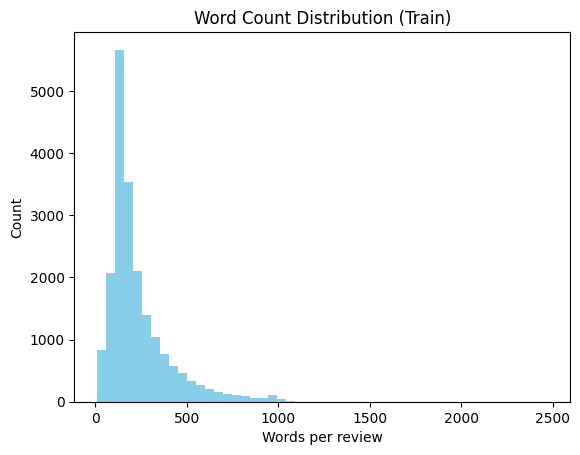

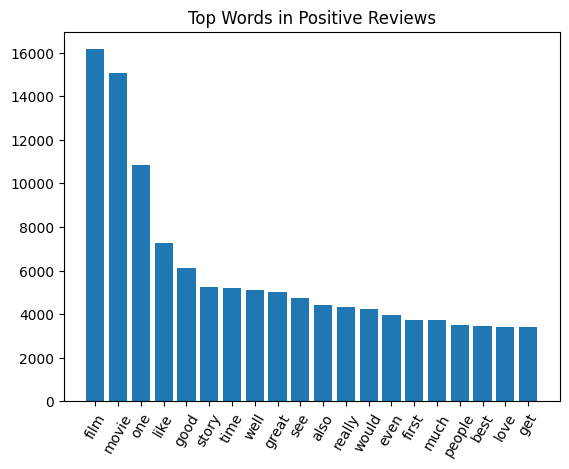

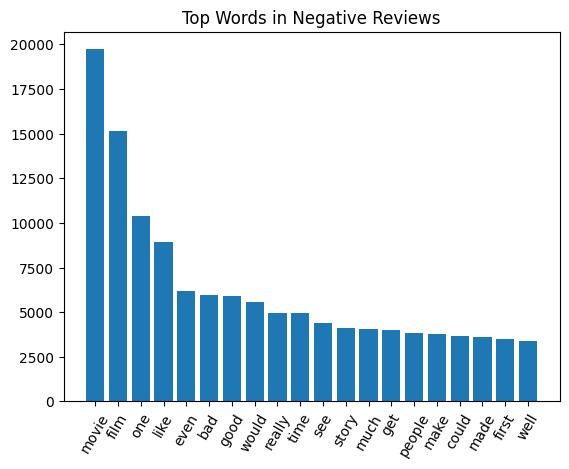

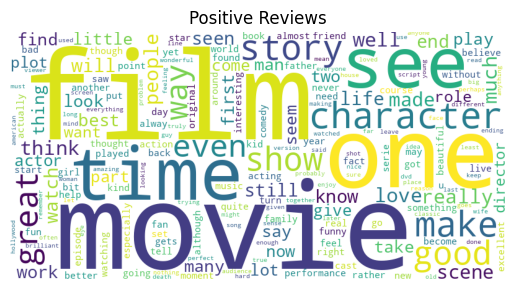

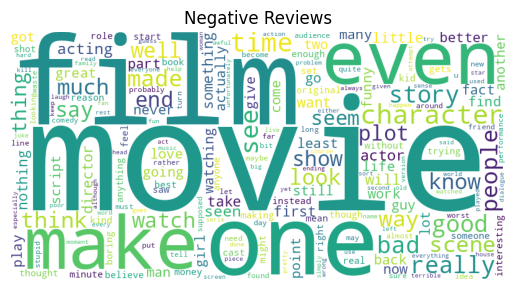

In [10]:
def plot_histogram(data, title, xlabel):
    plt.figure()
    plt.hist(data, bins=50, color="skyblue")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.show()

plot_histogram(train_df["word_count"], "Word Count Distribution (Train)", "Words per review")

# Top words (positive/negative)
def top_n_words(texts, n=20):
    counter = Counter()
    for t in texts:
        toks = tokenize_words(t)
        toks = [w for w in toks if w not in EN_STOPWORDS and len(w) > 2]
        counter.update(toks)
    return counter.most_common(n)

top_pos = top_n_words(train_df.loc[train_df["label"] == 1, "text_clean"])
top_neg = top_n_words(train_df.loc[train_df["label"] == 0, "text_clean"])

plt.bar(*zip(*top_pos))
plt.title("Top Words in Positive Reviews")
plt.xticks(rotation=60)
plt.show()

plt.bar(*zip(*top_neg))
plt.title("Top Words in Negative Reviews")
plt.xticks(rotation=60)
plt.show()

# Word clouds
wc_pos = WordCloud(width=800, height=400, background_color="white").generate(" ".join(train_df.loc[train_df["label"]==1,"text_clean"]))
plt.imshow(wc_pos); plt.axis("off"); plt.title("Positive Reviews"); plt.show()

wc_neg = WordCloud(width=800, height=400, background_color="white").generate(" ".join(train_df.loc[train_df["label"]==0,"text_clean"]))
plt.imshow(wc_neg); plt.axis("off"); plt.title("Negative Reviews"); plt.show()


In [11]:
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=50000, ngram_range=(1,2), min_df=2)),
    ("clf", LogisticRegression(max_iter=1000, random_state=42)),
])

pipeline.fit(train_df["text_clean"], train_df["label"])

valid_pred = pipeline.predict(valid_df["text_clean"])
print("Validation Accuracy:", accuracy_score(valid_df["label"], valid_pred))
print(classification_report(valid_df["label"], valid_pred))


test_pred = pipeline.predict(test_df["text_clean"])
print("Test Accuracy:", accuracy_score(test_df["label"], test_pred))
print(classification_report(test_df["label"], test_pred))


Validation Accuracy: 0.8958
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      2500
           1       0.89      0.90      0.90      2500

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000

Test Accuracy: 0.8904
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     12500
           1       0.89      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

